# Notbeook with part of final master work

This notebook is summary of all other phases + the generation and management of the databse.

This is the tool the client would use in daily basis to add new quotes to the database coming from Twitter.


## Libraries and load files in colab

In [11]:
# Libraries to load the dataframes
from google.colab import drive
import csv

# For preprocessing
import numpy as np
import pandas as pd 
import re

# For ML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping

# For plotting
import matplotlib.pyplot as plt

# For tweet processing
import tweepy
import datetime
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')   # download the stopwords from NLTK
import string # for string operations

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Here I load the files which where stored in my google colab. Please change path in case you want to use this.

In [12]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
rawdf = pd.read_csv('/content/drive/My Drive/VIU/TFM/3rd Iteration/quotes_phase0.csv', error_bad_lines=False, header=0)

In [20]:
#Best practise to avoid re-upload the dataset in case of errors
df = rawdf.copy(deep=True)

## Log into MondoDB Database "TFMDatabase"

Here we log into the MongoDB databse and create a database called TFMDatabase

In [ ]:
#Connected to MondoDB and database "TFMDatabase"
import pymongo
 
my_client = pymongo.MongoClient(
    #MongoDB client URL
)


In [ ]:
#Check MongoDB version
try:
    print("MongoDB version is %s" %
            my_client.server_info()['version'])
except pymongo.errors.OperationFailure as error:
    print(error)
    quit(1)

MongoDB version is 4.2.9


In [ ]:
#Connect to database (in my case called "TFMDatabase")
my_database = my_client.TFMDatabase
my_database

Database(MongoClient(host=['tfmdatabase-shard-00-01.4jk37.gcp.mongodb.net:27017', 'tfmdatabase-shard-00-02.4jk37.gcp.mongodb.net:27017', 'tfmdatabase-shard-00-00.4jk37.gcp.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, ssl=True, replicaset='atlas-mxwu07-shard-0', authsource='admin', retrywrites=True, w='majority'), 'TFMDatabase')

## Create data collection and store processed data in it

We create a data collection called "labelled_quotes" and add it into the database TFMDatabse.

Finally, we add the processed data "quotes_phase0" in it.

In [ ]:
#Create/connect a collection for the processed quotes in phase 0
labelled_quotes = my_database.labelled_quotes
labelled_quotes

In [21]:
df.shape

(367185, 2)

In [10]:
df.head()

,Quotes,Label
0,"I'm selfish, impatient and a little insecure. ...","attributed-no-source, best, life, love, mistak..."
1,You've gotta dance like there's nobody watchin...,"dance, heaven, hurt, inspirational, life, love..."
2,You know you're in love when you can't fall as...,"attributed-no-source, dreams, love, reality, s..."
3,A friend is someone who knows all about you an...,"friend, friendship, knowledge, love"
4,Darkness cannot drive out darkness: only light...,"darkness, drive-out, hate, inspirational, ligh..."


In [ ]:
with open('/content/drive/My Drive/VIU/TFM/3rd Iteration/quotes_phase0.csv') as f1:
  records=csv.reader(f1,delimiter=",")
  li=[]
  for record in records:
    dict={}
    Quote=record[0]
    Label=record[1]
    dict={'Quotes':Quote,'Label':Label}
    li.append(dict)

In [ ]:
# Add documents to the collection
labelled_quotes.insert_many(li)

In [ ]:
# Delete_one and delete_many to delete documents in the collection
labelled_quotes.delete_one({
    "Quotes": "Quotes",
    "Label": "Label"
})

## Model generation

This is part of notebook Phase 4: Modeling.

In [22]:
# Let's load the preprocessed dataset
rawdf = pd.read_csv('/content/drive/My Drive/VIU/TFM/3rd Iteration/quotes_phase4.csv', error_bad_lines=False, header=0)

In [23]:
# Let's load agaon the df
df = rawdf.copy(deep=True)

### Pre-processing

In [24]:
df['clean_doc'] = df['clean_doc'].astype(str)
df.head()

,Quotes,Label,clean_doc
0,"I'm selfish, impatient and a little insecure. ...",attributed-no-source best life love mistakes o...,selfish impatient little insecure make mistake...
1,You've gotta dance like there's nobody watchin...,dance heaven hurt inspirational life love sing,gotta dance nobody watching hurt sing nobody l...
2,You know you're in love when you can't fall as...,attributed-no-source dreams love reality sleep,know fall asleep reality finally better dreams
3,A friend is someone who knows all about you an...,friend friendship knowledge love,friend someone knows still loves
4,Darkness cannot drive out darkness: only light...,darkness drive-out hate inspirational light lo...,darkness cannot drive darkness light hate cann...


In [25]:
#We do it with this one step
df.Label = df.Label.apply(lambda x: x.replace(',',''))
df.Label = df.Label.apply(lambda x: x.lower())

In [26]:
labelskept = ['love', 'life', 'inspirational','humor', 'philosophy', 'god', 'truth','romance',
              'death','success','wisdom',
              'grief', 'faith', 'good', 'work',
              'happiness', 'hope', 'funny', 'fear', 
              'passion', 'imagination', 'motivational', 'compassion', 'freedom',
              'purpose', 'leadership', 'courage', 'peace', 'pain',
              'creativity']

test = pd.DataFrame(labelskept,columns=['labelskept'])
len(test.labelskept.unique())

30

In [27]:
#tokanizing label column
tokenized_doc = df.Label.apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item in labelskept])

# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df.Label = detokenized_doc
df.head()

,Quotes,Label,clean_doc
0,"I'm selfish, impatient and a little insecure. ...",life love truth,selfish impatient little insecure make mistake...
1,You've gotta dance like there's nobody watchin...,inspirational life love,gotta dance nobody watching hurt sing nobody l...
2,You know you're in love when you can't fall as...,love,know fall asleep reality finally better dreams
3,A friend is someone who knows all about you an...,love,friend someone knows still loves
4,Darkness cannot drive out darkness: only light...,inspirational love peace,darkness cannot drive darkness light hate cann...


In [28]:
df.shape

(367185, 3)

In [29]:
#Eliminate all rows without values
df.Label = df.Label.replace('',np.nan, regex=True)
df = df.dropna()

In [30]:
df.shape

(128068, 3)

In [31]:
#Let's check if its still multilabel
df['Label Count'] = 3
for ind, row in df.iterrows():
  df['Label Count'][ind] = len(row['Label'].split())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [32]:
df.head()

,Quotes,Label,clean_doc,Label Count
0,"I'm selfish, impatient and a little insecure. ...",life love truth,selfish impatient little insecure make mistake...,3
1,You've gotta dance like there's nobody watchin...,inspirational life love,gotta dance nobody watching hurt sing nobody l...,3
2,You know you're in love when you can't fall as...,love,know fall asleep reality finally better dreams,1
3,A friend is someone who knows all about you an...,love,friend someone knows still loves,1
4,Darkness cannot drive out darkness: only light...,inspirational love peace,darkness cannot drive darkness light hate cann...,3


In [33]:
# Delete multilables
df = df[df['Label Count'] == 1]
df.shape

(93395, 4)

### Modeling

**Vectorization**

In [36]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000


# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['clean_doc'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45444 unique tokens.


In [37]:
X = tokenizer.texts_to_sequences(df['clean_doc'].values)
X = pad_sequences(X, maxlen=30)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (93395, 30)


In [38]:
Y = pd.get_dummies(df['Label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (93395, 30)


**Data split**

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(84055, 30) (84055, 30)
(9340, 30) (9340, 30)


**Model CReateion**

In [43]:
model = Sequential()

# Configuring the parameters
model.add(Embedding(MAX_NB_WORDS, output_dim=20, input_length=X.shape[1]))

# Adding a dropout layer
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))

# Adding a dense output layer with softmax activation
model.add(Dense(30, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 20)            1000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 1,051,430
Trainable params: 1,051,430
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train, Y_train,
                    epochs=5,
                    batch_size=528,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
144/144 [==============================] - 46s 323ms/step - loss: 3.0414 - accuracy: 0.1621 - val_loss: 2.9560 - val_accuracy: 0.1652
Epoch 2/5
144/144 [==============================] - 46s 321ms/step - loss: 2.7738 - accuracy: 0.2106 - val_loss: 2.5778 - val_accuracy: 0.2675
Epoch 3/5
144/144 [==============================] - 46s 318ms/step - loss: 2.3929 - accuracy: 0.3258 - val_loss: 2.3173 - val_accuracy: 0.3615
Epoch 4/5
144/144 [==============================] - 46s 319ms/step - loss: 2.1255 - accuracy: 0.4079 - val_loss: 2.2143 - val_accuracy: 0.4085
Epoch 5/5
144/144 [==============================] - 48s 330ms/step - loss: 1.9552 - accuracy: 0.4591 - val_loss: 2.1776 - val_accuracy: 0.4190


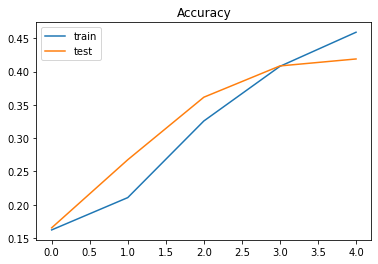

In [45]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Extract, clean, alssify and store tweets

### Extract

**Access to API**

In [ ]:
# Variables that contains the credentials to access Twitter API
ACCESS_TOKEN = 'XXXXXX'
ACCESS_SECRET = 'XXXXXX'
CONSUMER_KEY = 'XXXXXX'
CONSUMER_SECRET = 'XXXXXX'


# Setup access to API
def connect_to_twitter_OAuth():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    api = tweepy.API(auth)
    return api


# Create API object
api = connect_to_twitter_OAuth()

**Load tweets**

In [ ]:
# fuction to extract desired data from tweet object and concert it to df
def extract_tweet_attributes(tweet_object):
    # create empty list
    tweet_list =[]

    # loop through tweet objects
    for tweet in tweet_object:
      if (not tweet.retweeted) and ('RT @' not in tweet.full_text):

        #here the  attributes from the tweet object
        text = tweet.full_text # utf-8 text of tweet
        name = tweet.user.name # unique integer identifier for tweet

        # append attributes to list
        tweet_list.append({'text':text,'name':name})

    # create dataframe   
    df = pd.DataFrame(tweet_list, columns=['text','name'])

    return df

In [ ]:
# Accounts
user1 = 22256645    #@GreatestQuotes
user2 = 152856447   #_FeelingsQuote_
user3 = 23245396   #@quotepage
users = [user1, user2, user3]

In [ ]:
# Loop over users to extarct their tweets

# Initialize list tp keep tweets
totaltweets = []

# Loop to gather tweets from different users
for user in users:
  
  start_date= datetime.datetime(2020,9,2,00,00,00)
  end_date = datetime.datetime(2020,9,3,00,00,00)
  #Writting 00:00:00 you get all tweets from that day
  #End date write the day after the last one you want to analyse

  tweets = api.user_timeline(user_id=user, count=50, tweet_mode='extended')

  for tweet in tweets:
    if tweet.created_at < end_date and tweet.created_at > start_date:
      totaltweets.append(tweet)

dftweets = extract_tweet_attributes(totaltweets)
dftweets.head(20)

,text,name
0,"""I have two judges and two only; the ten year ...",Quote of the Day
1,"""You have brains in your head. Your feet in yo...",Quote of the Day


### Clean

In [ ]:
def checktweet(tweet):
  # remove hyperlinks
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)

  # remove hashtags with space before it
  tweet = re.sub(r'(\s)#\w+', r'', tweet)
 
  # remove hashtags without space before it
  tweet = re.sub(r'#\w+', r'', tweet)
  
  # remove mentions
  tweet = re.sub(r'(\s)@\w+', '', tweet)
  
  # remove author
  if len([pos for pos, char in enumerate(tweet) if char == '-']) > 0:
    tweet = tweet[:[pos for pos, char in enumerate(tweet) if char == '-'][-1]]


  # remove punctuations and convert characters to lower case
  tweet = "".join([char.lower() for char in tweet if char not in string.punctuation]) 

  # Also, removes leading and trailing whitespaces
  tweet = re.sub('\s+', ' ', tweet).strip()
  
  # remove stop words
  tweet = " ".join([word for word in tweet.split() if word not in stopwords.words('english')])


  if (len(tweet) > 280) or (len(tweet) < 20):
    return None
  else:  
    return tweet

In [ ]:
dftweets['text clean'] = dftweets.text.apply(lambda x: checktweet(x))
dftweets = dftweets.dropna()
dftweets

,text,name,text clean
0,"""I have two judges and two only; the ten year ...",Quote of the Day,two judges two ten year old inside told never ...
1,"""You have brains in your head. Your feet in yo...",Quote of the Day,brains head feet shoes steer direction choose


### Clasify

In [ ]:
#Create column converting texts to lists
dftweets['text ready'] = dftweets['text clean'].apply(lambda x: [str(x)])
dftweets

,text,name,text clean,text ready
0,"""I have two judges and two only; the ten year ...",Quote of the Day,two judges two ten year old inside told never ...,[two judges two ten year old inside told never...
1,"""You have brains in your head. Your feet in yo...",Quote of the Day,brains head feet shoes steer direction choose,[brains head feet shoes steer direction choose]


In [ ]:
# Creatig function to call the model

labels = ['compassion', 'courage', 'creativity', 'death', 'faith', 'fear',
       'freedom', 'funny', 'god', 'good', 'grief', 'happiness', 'hope',
       'humor', 'imagination', 'inspirational', 'leadership', 'life', 'love',
       'motivational', 'pain', 'passion', 'peace', 'philosophy', 'purpose',
       'romance', 'success', 'truth', 'wisdom', 'work']

def predictor(text):
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=140)
    pred = model.predict(padded)
    return labels[np.argmax(pred)]

In [ ]:
# Creating empty column for labelling and labelling
dftweets['results']='empty'
dftweets.results = dftweets['text ready'].apply(lambda x: predictor(x))
dftweets[0:30]

,text,name,text clean,text ready,results
0,"""I have two judges and two only; the ten year ...",Quote of the Day,two judges two ten year old inside told never ...,[two judges two ten year old inside told never...,death
1,"""You have brains in your head. Your feet in yo...",Quote of the Day,brains head feet shoes steer direction choose,[brains head feet shoes steer direction choose],humor


### Store

In [ ]:
# We need to rearrenge the dataframe a bit
dftweets = dftweets.drop(columns=['name','text clean','text ready'])
dftweets = dftweets.rename(columns={"text": "Quotes", "results": "Label"})
dftweets

,Quotes,Label
0,"""I have two judges and two only; the ten year ...",death
1,"""You have brains in your head. Your feet in yo...",humor


In [ ]:
#To store we need to firt convert it to a dictionary
dftweets.reset_index(inplace=True)
data_dict = dftweets.to_dict("records")
data_dict

[{'Label': 'death',
  'Quotes': '"I have two judges and two only; the ten year old inside who told me never to stop dreaming and the dying man who told me never to stop living." - Raphie Frank',
  'index': 0},
 {'Label': 'humor',
  'Quotes': '"You have brains in your head. Your feet in your shoes. You can steer yourself in any direction you choose." - Theodor Seuss Geisel',
  'index': 1}]

In [ ]:
#Insert
labelled_quotes.insert_one({"data":data_dict})